In [4]:
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
import seaborn 
import scipy
import sklearn
from scipy import sparse
from scipy.sparse import hstack
%matplotlib inline

## Reading in Data

In [30]:
data = pd.read_csv("data/walmart-triptype-train.csv.gz")
data_original = pd.read_csv("data/walmart-triptype-train.csv.gz")
w_test_data = pd.read_csv("data/walmart-triptype-test.csv.gz")

#sample_submission = pd.read_csv("sample_submission (1).csv")

In [23]:
data_original.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [24]:
w_test_data.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,1,Friday,7.250339e+10,1,SHOES,3002.0
1,1,Friday,1.707711e+09,1,DAIRY,1526.0
2,1,Friday,8.947000e+10,1,DAIRY,1431.0
3,1,Friday,8.849121e+10,1,GROCERY DRY GOODS,3555.0
4,2,Friday,2.840015e+09,1,DSD GROCERY,4408.0


## Data Cleaning and Feature Engineering

In [25]:
def transform_my_data(data):
    
    dummies = pd.get_dummies(data.DepartmentDescription)
    data[dummies.columns] = dummies 
    data['Weekday'] = data['Weekday'].map({"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, 
                                           "Saturday": 6, "Sunday": 7})
    data_dummies = data.iloc[:,7:]
    data_dummies = data_dummies.apply(lambda x: x*data["ScanCount"])
    data_dummies = data_dummies.replace(-0,0)

    data.loc[data.ScanCount < 0, 'Return'] = 1
    data.loc[data.Return != 1, 'Return'] = 0
    #data = data[["TripType", "VisitNumber", "Weekday", "ScanCount", "Return"]]
    data = data.rename(columns={"ScanCount":"NumItems"})
    #data = pd.concat([data, data_dummies], axis=1)
    grouped = data.groupby("VisitNumber")
    grouped = grouped.agg({'Weekday': np.max, "TripType": np.max, 'NumItems': np.sum, 'Return': np.max, 
              '1-HR PHOTO': np.sum, 'ACCESSORIES': np.sum,
       'AUTOMOTIVE': np.sum, 'BAKERY': np.sum, 'BATH AND SHOWER': np.sum, 'BEAUTY': np.sum, 'BEDDING': np.sum,
       'BOOKS AND MAGAZINES': np.sum, 'BOYS WEAR': np.sum, 'BRAS & SHAPEWEAR': np.sum,
       'CAMERAS AND SUPPLIES': np.sum, 'CANDY, TOBACCO, COOKIES': np.sum, 'CELEBRATION': np.sum,
       'COMM BREAD': np.sum, 'CONCEPT STORES': np.sum, 'COOK AND DINE': np.sum, 'DAIRY': np.sum, 'DSD GROCERY': np.sum,
       'ELECTRONICS': np.sum, 'FABRICS AND CRAFTS': np.sum, 'FINANCIAL SERVICES': np.sum,
       'FROZEN FOODS': np.sum, 'FURNITURE': np.sum, 'GIRLS WEAR, 4-6X  AND 7-14': np.sum,
       'GROCERY DRY GOODS': np.sum, 'HARDWARE': np.sum, 'HEALTH AND BEAUTY AIDS': np.sum, 'HOME DECOR': np.sum,
       'HOME MANAGEMENT': np.sum, 'HORTICULTURE AND ACCESS': np.sum,
       'HOUSEHOLD CHEMICALS/SUPP': np.sum, 'HOUSEHOLD PAPER GOODS': np.sum,
       'IMPULSE MERCHANDISE': np.sum, 'INFANT APPAREL': np.sum, 'INFANT CONSUMABLE HARDLINES': np.sum,
       'JEWELRY AND SUNGLASSES': np.sum, 'LADIES SOCKS': np.sum, 'LADIESWEAR': np.sum,
       'LARGE HOUSEHOLD GOODS': np.sum, 'LAWN AND GARDEN': np.sum, 'LIQUOR,WINE,BEER': np.sum,
       'MEAT - FRESH & FROZEN': np.sum, 'MEDIA AND GAMING': np.sum, 'MENSWEAR': np.sum,
       'OFFICE SUPPLIES': np.sum, 'OPTICAL - FRAMES': np.sum, 'OPTICAL - LENSES': np.sum,
       'OTHER DEPARTMENTS': np.sum, 'PAINT AND ACCESSORIES': np.sum, 'PERSONAL CARE': np.sum,
       'PETS AND SUPPLIES': np.sum, 'PHARMACY OTC': np.sum, 'PHARMACY RX': np.sum,
       'PLAYERS AND ELECTRONICS': np.sum, 'PLUS AND MATERNITY': np.sum, 'PRE PACKED DELI': np.sum,
       'PRODUCE': np.sum, 'SEAFOOD': np.sum, 'SEASONAL': np.sum, 'SERVICE DELI': np.sum, 'SHEER HOSIERY': np.sum,
       'SHOES': np.sum, 'SLEEPWEAR/FOUNDATIONS': np.sum, 'SPORTING GOODS': np.sum,
       'SWIMWEAR/OUTERWEAR': np.sum, 'TOYS': np.sum, 'WIRELESS': np.sum})
    data = grouped[["TripType", "Weekday", "NumItems", "Return",'1-HR PHOTO', 'ACCESSORIES',
           'AUTOMOTIVE', 'BAKERY', 'BATH AND SHOWER', 'BEAUTY', 'BEDDING',
           'BOOKS AND MAGAZINES', 'BOYS WEAR', 'BRAS & SHAPEWEAR',
           'CAMERAS AND SUPPLIES', 'CANDY, TOBACCO, COOKIES', 'CELEBRATION',
           'COMM BREAD', 'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY',
           'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES',
           'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14',
           'GROCERY DRY GOODS', 'HARDWARE', 'HEALTH AND BEAUTY AIDS', 'HOME DECOR',
           'HOME MANAGEMENT', 'HORTICULTURE AND ACCESS',
           'HOUSEHOLD CHEMICALS/SUPP', 'HOUSEHOLD PAPER GOODS',
           'IMPULSE MERCHANDISE', 'INFANT APPAREL', 'INFANT CONSUMABLE HARDLINES',
           'JEWELRY AND SUNGLASSES', 'LADIES SOCKS', 'LADIESWEAR',
           'LARGE HOUSEHOLD GOODS', 'LAWN AND GARDEN', 'LIQUOR,WINE,BEER',
           'MEAT - FRESH & FROZEN', 'MEDIA AND GAMING', 'MENSWEAR',
           'OFFICE SUPPLIES', 'OPTICAL - FRAMES', 'OPTICAL - LENSES',
           'OTHER DEPARTMENTS', 'PAINT AND ACCESSORIES', 'PERSONAL CARE',
           'PETS AND SUPPLIES', 'PHARMACY OTC', 'PHARMACY RX',
           'PLAYERS AND ELECTRONICS', 'PLUS AND MATERNITY', 'PRE PACKED DELI',
           'PRODUCE', 'SEAFOOD', 'SEASONAL', 'SERVICE DELI', 'SHEER HOSIERY',
           'SHOES', 'SLEEPWEAR/FOUNDATIONS', 'SPORTING GOODS',
           'SWIMWEAR/OUTERWEAR', 'TOYS', 'WIRELESS']]
    data['TripType'] = data['TripType'].map({3:0, 4:1, 5:2, 6:3, 7:4, 8:5, 9:6, 12:7, 14:8, 15:9,  
                                         18:10, 19:11, 20:12, 21:13, 22:14, 23:15, 24:16, 25:17, 26:18,  
                                         27:19, 28:20, 29:21, 30:22, 31:23, 32:24, 33:25, 34:26, 35:27, 
                                         36:28, 37:29, 38:30, 39:31, 40:32, 41:33, 42:34, 43:35, 44:36, 999:37})
    return data

In [31]:
data = transform_my_data(data_original)

In [19]:
def transform_w_data(data):
    dummies = pd.get_dummies(data.DepartmentDescription)
    data[dummies.columns] = dummies 
    data['Weekday'] = data['Weekday'].map({"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5,
                                           "Saturday": 6, "Sunday": 7})
    data_dummies = data.iloc[:,7:]
    data_dummies = data_dummies.apply(lambda x: x*data["ScanCount"])
    data_dummies = data_dummies.replace(-0,0)
    data.loc[data.ScanCount < 0, 'Return'] = 1
    data.loc[data.Return != 1, 'Return'] = 0
    data = data[["VisitNumber", "Weekday", "ScanCount", "Return"]]
    data = data.rename(columns={"ScanCount":"NumItems"})
    data = pd.concat([data, data_dummies], axis=1)
    grouped = data.groupby("VisitNumber")
    grouped = grouped.agg({'Weekday': np.max, 'NumItems': np.sum, 'Return': np.max, 
                'ACCESSORIES': np.sum,
           'AUTOMOTIVE': np.sum, 'BAKERY': np.sum, 'BATH AND SHOWER': np.sum, 'BEAUTY': np.sum, 'BEDDING': np.sum,
           'BOOKS AND MAGAZINES': np.sum, 'BOYS WEAR': np.sum, 'BRAS & SHAPEWEAR': np.sum,
           'CAMERAS AND SUPPLIES': np.sum, 'CANDY, TOBACCO, COOKIES': np.sum, 'CELEBRATION': np.sum,
           'COMM BREAD': np.sum, 'CONCEPT STORES': np.sum, 'COOK AND DINE': np.sum, 'DAIRY': np.sum, 'DSD GROCERY': np.sum,
           'ELECTRONICS': np.sum, 'FABRICS AND CRAFTS': np.sum, 'FINANCIAL SERVICES': np.sum,
           'FROZEN FOODS': np.sum, 'FURNITURE': np.sum, 'GIRLS WEAR, 4-6X  AND 7-14': np.sum,
           'GROCERY DRY GOODS': np.sum, 'HARDWARE': np.sum, 'HOME DECOR': np.sum,
           'HOME MANAGEMENT': np.sum, 'HORTICULTURE AND ACCESS': np.sum,
           'HOUSEHOLD CHEMICALS/SUPP': np.sum, 'HOUSEHOLD PAPER GOODS': np.sum,
           'IMPULSE MERCHANDISE': np.sum, 'INFANT APPAREL': np.sum, 'INFANT CONSUMABLE HARDLINES': np.sum,
           'JEWELRY AND SUNGLASSES': np.sum, 'LADIES SOCKS': np.sum, 'LADIESWEAR': np.sum,
           'LARGE HOUSEHOLD GOODS': np.sum, 'LAWN AND GARDEN': np.sum, 'LIQUOR,WINE,BEER': np.sum,
           'MEAT - FRESH & FROZEN': np.sum, 'MEDIA AND GAMING': np.sum, 'MENSWEAR': np.sum,
           'OFFICE SUPPLIES': np.sum, 'OPTICAL - FRAMES': np.sum, 'OPTICAL - LENSES': np.sum,
           'OTHER DEPARTMENTS': np.sum, 'PAINT AND ACCESSORIES': np.sum, 'PERSONAL CARE': np.sum,
           'PETS AND SUPPLIES': np.sum, 'PHARMACY OTC': np.sum, 'PHARMACY RX': np.sum,
           'PLAYERS AND ELECTRONICS': np.sum, 'PLUS AND MATERNITY': np.sum, 'PRE PACKED DELI': np.sum,
           'PRODUCE': np.sum, 'SEAFOOD': np.sum, 'SEASONAL': np.sum, 'SERVICE DELI': np.sum, 'SHEER HOSIERY': np.sum,
           'SHOES': np.sum, 'SLEEPWEAR/FOUNDATIONS': np.sum, 'SPORTING GOODS': np.sum,
           'SWIMWEAR/OUTERWEAR': np.sum, 'TOYS': np.sum, 'WIRELESS': np.sum})
    data = grouped[["Weekday", "NumItems", "Return", 'ACCESSORIES',
               'AUTOMOTIVE', 'BAKERY', 'BATH AND SHOWER', 'BEAUTY', 'BEDDING',
               'BOOKS AND MAGAZINES', 'BOYS WEAR', 'BRAS & SHAPEWEAR',
               'CAMERAS AND SUPPLIES', 'CANDY, TOBACCO, COOKIES', 'CELEBRATION',
               'COMM BREAD', 'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY',
               'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES',
               'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14',
               'GROCERY DRY GOODS', 'HARDWARE', 'HOME DECOR',
               'HOME MANAGEMENT', 'HORTICULTURE AND ACCESS',
               'HOUSEHOLD CHEMICALS/SUPP', 'HOUSEHOLD PAPER GOODS',
               'IMPULSE MERCHANDISE', 'INFANT APPAREL', 'INFANT CONSUMABLE HARDLINES',
               'JEWELRY AND SUNGLASSES', 'LADIES SOCKS', 'LADIESWEAR',
               'LARGE HOUSEHOLD GOODS', 'LAWN AND GARDEN', 'LIQUOR,WINE,BEER',
               'MEAT - FRESH & FROZEN', 'MEDIA AND GAMING', 'MENSWEAR',
               'OFFICE SUPPLIES', 'OPTICAL - FRAMES', 'OPTICAL - LENSES',
               'OTHER DEPARTMENTS', 'PAINT AND ACCESSORIES', 'PERSONAL CARE',
               'PETS AND SUPPLIES', 'PHARMACY OTC', 'PHARMACY RX',
               'PLAYERS AND ELECTRONICS', 'PLUS AND MATERNITY', 'PRE PACKED DELI',
               'PRODUCE', 'SEAFOOD', 'SEASONAL', 'SERVICE DELI', 'SHEER HOSIERY',
               'SHOES', 'SLEEPWEAR/FOUNDATIONS', 'SPORTING GOODS',
               'SWIMWEAR/OUTERWEAR', 'TOYS', 'WIRELESS']]
    #data['TripType'] = data['TripType'].map({3:0, 4:1, 5:2, 6:3, 7:4, 8:5, 9:6, 12:7, 14:8, 15:9,  
                                         #18:10, 19:11, 20:12, 21:13, 22:14, 23:15, 24:16, 25:17, 26:18,  
                                         #27:19, 28:20, 29:21, 30:22, 31:23, 32:24, 33:25, 34:26, 35:27, 
                                         #36:28, 37:29, 38:30, 39:31, 40:32, 41:33, 42:34, 43:35, 44:36, 999:37})
    return data

In [28]:
test = transform_w_data(w_test_data)

In [32]:
def add_category_counts(data):
    alist = []
    for array in np.asarray(data.iloc[:,4:]):
        count = 0
        for item in array:
            if item > 0:
                count += 1
        alist.append(count)
    cat_counts = pd.DataFrame(alist)
    cat_counts = cat_counts.rename(columns={0:"CategoryCount"})
    cat_counts = cat_counts.set_index(data.index)
    data.insert(4, 'CategoryCounts', cat_counts)
    return data

def add_category_counts_test(data):
    alist = []
    for array in np.asarray(data.iloc[:,3:]):
        count = 0
        for item in array:
            if item > 0:
                count += 1
        alist.append(count)
    cat_counts = pd.DataFrame(alist)
    cat_counts = cat_counts.rename(columns={0:"CategoryCount"})
    cat_counts = cat_counts.set_index(data.index)
    data.insert(3, 'CategoryCounts', cat_counts)
    return data

In [33]:
data = add_category_counts(data)

In [34]:
data.head()

,TripType,Weekday,NumItems,Return,CategoryCounts,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,37,5,-1,1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,22,5,2,0.0,2,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,18,5,28,1.0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,5,5,3,0.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,5,5,3,0.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
data_original.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,...,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,Return
0,999,5,5,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,30,7,5,6.053882e+10,1,SHOES,8931.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.0
2,30,7,5,7.410811e+09,1,PERSONAL CARE,4504.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,26,8,5,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,26,8,5,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [48]:
test = add_category_counts_test(test)

In [28]:
test.head()

,Weekday,NumItems,Return,CategoryCounts,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
1,5,4,0,3,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,5,4,0,3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,5,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
test_features = ["Weekday", "NumItems", "Return", 'CategoryCounts', 'ACCESSORIES', 
           'AUTOMOTIVE', 'BAKERY', 'BATH AND SHOWER', 'BEAUTY', 'BEDDING',
           'BOOKS AND MAGAZINES', 'BOYS WEAR', 'BRAS & SHAPEWEAR',
           'CAMERAS AND SUPPLIES', 'CANDY, TOBACCO, COOKIES', 'CELEBRATION',
           'COMM BREAD', 'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY',
           'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES',
           'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14',
           'GROCERY DRY GOODS', 'HARDWARE', 'HOME DECOR',
           'HOME MANAGEMENT', 'HORTICULTURE AND ACCESS',
           'HOUSEHOLD CHEMICALS/SUPP', 'HOUSEHOLD PAPER GOODS',
           'IMPULSE MERCHANDISE', 'INFANT APPAREL', 'INFANT CONSUMABLE HARDLINES',
           'JEWELRY AND SUNGLASSES', 'LADIES SOCKS', 'LADIESWEAR',
           'LARGE HOUSEHOLD GOODS', 'LAWN AND GARDEN', 'LIQUOR,WINE,BEER',
           'MEAT - FRESH & FROZEN', 'MEDIA AND GAMING', 'MENSWEAR',
           'OFFICE SUPPLIES', 'OPTICAL - FRAMES', 'OPTICAL - LENSES',
           'OTHER DEPARTMENTS', 'PAINT AND ACCESSORIES', 'PERSONAL CARE',
           'PETS AND SUPPLIES', 'PHARMACY OTC', 'PHARMACY RX',
           'PLAYERS AND ELECTRONICS', 'PLUS AND MATERNITY', 'PRE PACKED DELI',
           'PRODUCE', 'SEAFOOD', 'SEASONAL', 'SERVICE DELI', 'SHEER HOSIERY',
           'SHOES', 'SLEEPWEAR/FOUNDATIONS', 'SPORTING GOODS',
           'SWIMWEAR/OUTERWEAR', 'TOYS', 'WIRELESS']
features = ["Weekday", "NumItems", "Return", 'CategoryCounts', 'ACCESSORIES',
       'AUTOMOTIVE', 'BAKERY', 'BATH AND SHOWER', 'BEAUTY', 'BEDDING',
       'BOOKS AND MAGAZINES', 'BOYS WEAR', 'BRAS & SHAPEWEAR',
       'CAMERAS AND SUPPLIES', 'CANDY, TOBACCO, COOKIES', 'CELEBRATION',
       'COMM BREAD', 'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY',
       'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES',
       'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14',
       'GROCERY DRY GOODS', 'HARDWARE', 'HOME DECOR',
       'HOME MANAGEMENT', 'HORTICULTURE AND ACCESS',
       'HOUSEHOLD CHEMICALS/SUPP', 'HOUSEHOLD PAPER GOODS',
       'IMPULSE MERCHANDISE', 'INFANT APPAREL', 'INFANT CONSUMABLE HARDLINES',
       'JEWELRY AND SUNGLASSES', 'LADIES SOCKS', 'LADIESWEAR',
       'LARGE HOUSEHOLD GOODS', 'LAWN AND GARDEN', 'LIQUOR,WINE,BEER',
       'MEAT - FRESH & FROZEN', 'MEDIA AND GAMING', 'MENSWEAR',
       'OFFICE SUPPLIES', 'OPTICAL - FRAMES', 'OPTICAL - LENSES',
       'OTHER DEPARTMENTS', 'PAINT AND ACCESSORIES', 'PERSONAL CARE',
       'PETS AND SUPPLIES', 'PHARMACY OTC', 'PHARMACY RX',
       'PLAYERS AND ELECTRONICS', 'PLUS AND MATERNITY', 'PRE PACKED DELI',
       'PRODUCE', 'SEAFOOD', 'SEASONAL', 'SERVICE DELI', 'SHEER HOSIERY',
       'SHOES', 'SLEEPWEAR/FOUNDATIONS', 'SPORTING GOODS',
       'SWIMWEAR/OUTERWEAR', 'TOYS', 'WIRELESS']

## Modeling

### Logistic Regression

In [44]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [45]:
mytrain, mytest = train_test_split(data, test_size = .4)
mytrain.TripType = mytrain.TripType.astype(float)
mytrain.Weekday = mytrain.Weekday.astype(float)  
mytrain.NumItems = mytrain.NumItems.astype(float)                         
mytest.TripType = mytest.TripType.astype(float)
mytest.Weekday = mytest.Weekday.astype(float)  
mytest.NumItems = mytest.NumItems.astype(float) 

/usr/local/lib/python3.4/dist-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [46]:
lr = LogisticRegression()
lr.fit(X = np.asarray(mytrain[features]), y = np.asarray(mytrain.TripType))

predictions = lr.predict_proba(np.asarray(mytest[features]))
predictions_notproba = lr.predict(np.asarray(mytest[features]))

print("Log loss Percentage: {}".format(log_loss(mytest.TripType, predictions).round(5)))

print("Accuracy Score: {}".format(sklearn.metrics.accuracy_score(mytest.TripType, predictions_notproba)))

Log loss Percentage: 1.22879
Accuracy Score: 0.6491246407107395


/usr/lib/python3/dist-packages/scipy/sparse/compressed.py:130: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.indices) != 1 or np.rank(self.indptr) != 1:
/usr/lib/python3/dist-packages/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:


### Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier
import sklearn

In [50]:
forest = RandomForestClassifier(n_estimators = 300, max_features=2)

In [51]:
forest = forest.fit(np.asarray(mytrain[features]), 
                    np.asarray(mytrain.TripType))

In [55]:
predictions = forest.predict_proba(np.asarray(mytest[features]))
predictions_notproba = forest.predict(np.asarray(mytest[features]))
print("Log loss Score: {}".format(log_loss(mytest.TripType, predictions).round(5)))
print("Accuracy Score: {}".format(sklearn.metrics.accuracy_score(mytest.TripType, predictions_notproba)))

Log loss Score: 1.31765
Accuracy Score: 0.667389600209041


### Extra Trees 

In [52]:
from sklearn.ensemble import ExtraTreesClassifier
extratrees = ExtraTreesClassifier(n_estimators = 100, max_features=3)
extratrees = extratrees.fit(np.asarray(mytrain[features]), 
                    np.asarray(mytrain.TripType))

In [61]:
predictions = extratrees.predict_proba(np.asarray(mytest[features]))
print("Log loss Score: {}".format(log_loss(mytest.TripType, predictions).round(5)))

Log loss Score: 2.27976


### Naive Bayes

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of independence between every pair of features. 

Can't use multinomial distribution because it needs all positive feature values, and some of mine are negative due to returns'

Oordinary Naive Bayes won't work welll but we can try BernoulliNB

In [71]:
bnb = BernoulliNB()
bnb = bnb.fit(np.asarray(mytrain[features]), 
                    np.asarray(mytrain.TripType))

In [72]:
predictions = bnb.predict_proba(np.asarray(mytest[test_features]))
print("Log loss Score: {}".format(log_loss(mytest.TripType, predictions).round(5)))

Log loss Score: 1.3847


Bernoulli Naive Bayes worked much better.

BernoulliNB implements the naive Bayes training and classification algorithms for data that is distributed according to multivariate Bernoulli distributions; i.e., there may be multiple features but each one is assumed to be a binary-valued (Bernoulli, boolean) variable. Therefore, this class requires samples to be represented as binary-valued feature vectors; if handed any other kind of data, a BernoulliNB instance may binarize its input (depending on the binarize parameter).

### Nearest Neighbor

In [19]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

In [25]:
knc = KNeighborsClassifier()

In [219]:
knc = knc.fit(np.asarray(mytrain[features]), 
                    np.asarray(mytrain.TripType))

In [75]:
predictions = knc.predict_proba(np.asarray(mytest[features]))
log_loss(mytest.TripType, predictions).round(5)

6.26328

In [76]:
knc = KNeighborsClassifier(algorithm='ball_tree')

In [77]:
knc = knc.fit(np.asarray(mytrain[features]), 
                    np.asarray(mytrain.TripType))
predictions = knc.predict_proba(np.asarray(mytest[features]))
log_loss(mytest.TripType, predictions).round(5)

6.3121700000000001

In [29]:
### Linear and Quadratic Discriminant Analysis

In [67]:
from sklearn.svm import LinearSVC

In [68]:
lsvc = LinearSVC()
lsvc = lsvc.fit(np.asarray(mytrain[features]), 
                    np.asarray(mytrain.TripType))

In [74]:
predictions = lsvc.decision_function(np.asarray(mytest[features]))
log_loss(mytest.TripType, predictions).round(5)

4.4655800000000001

### XGBoost (eXtreme Gradient Boosting, or Boosted Trees)

In [53]:
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss

In [58]:
data = pd.read_csv("data/walmart-triptype-train.csv.gz")

In [59]:
dummy_data = fineline_dummies(data)

MemoryError: 

In [1468]:
data = transform_my_data(data)

In [1469]:
data = add_category_counts(data)

In [1475]:
mytrain, mytest = train_test_split(data, test_size = .4)

In [1481]:
mytrain_train = mytrain[features]
mytest_train = mytest[test_features]
mytrain_train = mytrain_train.join(dummy_data)
mytest_train = mytest_train.join(dummy_data)

In [1482]:
dtrain = xgb.DMatrix(np.asarray(mytrain_train), label = np.asarray(mytrain.TripType))
dtest = xgb.DMatrix(np.asarray(mytest_train), label = np.asarray(mytest.TripType))

In [1483]:
num_round = 200
param = {'objective': 'multi:softprob', 'num_class':38, 
         'eval_metric': 'mlogloss', "max_delta_step": 5}
watchlist = [(dtrain,'train'), (dtest, 'eval')]


In [1484]:
bst = xgb.train(param, dtrain, num_round, watchlist, 
                early_stopping_rounds=3)

Will train until eval error hasn't decreased in 3 rounds.
[0]	train-mlogloss:2.423331	eval-mlogloss:2.459086
[1]	train-mlogloss:1.844753	eval-mlogloss:1.903898
[2]	train-mlogloss:1.577973	eval-mlogloss:1.652890
[3]	train-mlogloss:1.399409	eval-mlogloss:1.486069
[4]	train-mlogloss:1.273097	eval-mlogloss:1.369896
[5]	train-mlogloss:1.175256	eval-mlogloss:1.281284
[6]	train-mlogloss:1.098506	eval-mlogloss:1.212533
[7]	train-mlogloss:1.037998	eval-mlogloss:1.160038
[8]	train-mlogloss:0.987436	eval-mlogloss:1.116726
[9]	train-mlogloss:0.945993	eval-mlogloss:1.081721
[10]	train-mlogloss:0.910865	eval-mlogloss:1.052362
[11]	train-mlogloss:0.881344	eval-mlogloss:1.029085
[12]	train-mlogloss:0.854650	eval-mlogloss:1.008608
[13]	train-mlogloss:0.832596	eval-mlogloss:0.991987
[14]	train-mlogloss:0.812570	eval-mlogloss:0.977884
[15]	train-mlogloss:0.794244	eval-mlogloss:0.965146
[16]	train-mlogloss:0.777982	eval-mlogloss:0.954058
[17]	train-mlogloss:0.762627	eval-mlogloss:0.943604
[18]	train-mlogl

In [536]:
my_test = xgb.DMatrix(np.asarray(mytest_train))
test_predictions = bst1.predict(my_test)
log_loss(mytest.TripType, test_predictions).round(5)

In [1485]:
my_test1 = xgb.DMatrix(np.asarray(mytest_train))
test_predictions1 = bst.predict(my_test1)

In [1486]:
log_loss(mytest.TripType, test_predictions1).round(5)

0.84730000000000005

Massive Improvement in the log loss score by using xgboost

In [1581]:
test_predictions.head()

,WalmartClass,Prediction,Result
VisitNumber,,,
109535,39,39,1
65795,25,25,1
81674,999,999,1
71747,40,40,1
55413,40,40,1


In [491]:
##predicting percentage accuracy and individual predictions

num_round = 200
param1 = {'objective': 'multi:softmax', 'num_class':38, "max_delta_step": 1}
watchlist1 = [(dtrain,'train'), (dtest, 'eval')]

bst1 = xgb.train(param1, dtrain, num_round, watchlist1, early_stopping_rounds=5)

Will train until eval error hasn't decreased in 5 rounds.
[0]	train-merror:0.546425	eval-merror:0.552443
[1]	train-merror:0.503693	eval-merror:0.514711
[2]	train-merror:0.450892	eval-merror:0.465874
[3]	train-merror:0.402237	eval-merror:0.423047
[4]	train-merror:0.369243	eval-merror:0.392684
[5]	train-merror:0.324612	eval-merror:0.354194
[6]	train-merror:0.315657	eval-merror:0.346616
[7]	train-merror:0.310396	eval-merror:0.342461
[8]	train-merror:0.301617	eval-merror:0.336321
[9]	train-merror:0.293011	eval-merror:0.329997
[10]	train-merror:0.288029	eval-merror:0.324928
[11]	train-merror:0.281357	eval-merror:0.318997
[12]	train-merror:0.277786	eval-merror:0.318265
[13]	train-merror:0.273535	eval-merror:0.313797
[14]	train-merror:0.263135	eval-merror:0.305095
[15]	train-merror:0.258710	eval-merror:0.304547
[16]	train-merror:0.252317	eval-merror:0.300235
[17]	train-merror:0.249390	eval-merror:0.299190
[18]	train-merror:0.246411	eval-merror:0.298249
[19]	train-merror:0.242596	eval-merror:0

XGBoost had 72% accuracy

test data 

In [459]:
w_test_data = pd.read_csv("test 2 (1).csv")
test = transform_w_data(w_test_data)

In [212]:
test = add_category_counts_test(test)

In [214]:
test = fineline_dummies_test(test)

In [215]:
walmart_test = xgb.DMatrix(np.asarray(test))
predictions = bst.predict(walmart_test)

In [216]:
# remember to change .csv file before entering
predictions_to_csv(predictions)

### Using Most Frequent Fineline Numbers

In [56]:
def fineline_dummies(original_data):
    fineline_ranks = original_data.FinelineNumber.value_counts()
    fineline_ranks = fineline_ranks[fineline_ranks > 500]
    columns1 = list(fineline_ranks.index)
    dummies = pd.get_dummies(original_data.FinelineNumber)
    dummies = dummies[columns1]
    data_visit = original_data[["VisitNumber"]]
    dummy_data = pd.concat([dummies, data_visit], axis=1)
    dummy_data = dummy_data.groupby("VisitNumber")
    dummy_data = dummy_data.aggregate(np.sum)
    return dummy_data

def fineline_dummies_test(test):
    data1 = pd.read_csv("train.csv")
    fineline_ranks = data1.FinelineNumber.value_counts()
    fineline_ranks = fineline_ranks[fineline_ranks > 500]
    columns1 = list(fineline_ranks.index)
    data1 = pd.read_csv("test 2 (1).csv")
    dummies = pd.get_dummies(data1.FinelineNumber)
    dummies = dummies[columns1]
    data_visit = data1[["VisitNumber"]]
    dummy_data = pd.concat([dummies, data_visit], axis=1)
    dummy_data = dummy_data.groupby("VisitNumber")
    dummy_data = dummy_data.aggregate(np.sum)
    test = test.join(dummy_data)
    return test

## Modeling the Test Data and Exporting to CSV

logistic regression

In [65]:
test_predictions = lr.predict_proba(np.asarray(test[test_features]))

In [33]:
def predictions_to_csv(test_predictions):
    test_predictions = pd.DataFrame(test_predictions)
    test_indexes = test.index
    test_predictions = test_predictions.rename(columns = {0:"TripType_3", 1: "TripType_4", 2: "TripType_5", 3: "TripType_6", 
                4: "TripType_7", 5: "TripType_8", 6: "TripType_9", 7: "TripType_12", 8: "TripType_14", 
                9: "TripType_15", 10: "TripType_18", 11: "TripType_19", 12: "TripType_20", 13: "TripType_21",
                14: "TripType_22", 15: "TripType_23", 16: "TripType_24", 17: "TripType_25", 18: "TripType_26", 
                19: "TripType_27", 20: "TripType_28", 21: "TripType_29", 22: "TripType_30", 23: "TripType_31", 
                24: "TripType_32", 25: "TripType_33", 26: "TripType_34", 27: "TripType_35", 28: "TripType_36", 
                29: "TripType_37", 30: "TripType_38", 31: "TripType_39", 32: "TripType_40", 33: "TripType_41", 
                34: "TripType_42", 35: "TripType_43", 36: "TripType_44", 37: "TripType_999"})
    test_predictions.insert(0, 'VisitNumber', test_indexes)
    return test_predictions.to_csv("submissions/fifth_fineline_xgb.csv", index=False)

In [120]:
predictions.to_csv("submissions/fourth_fineline_xgb.csv", index=False)

random forest, 300 classifiers

In [146]:
test_predictions = forest.predict_proba(np.asarray(test[test_features]))

In [147]:
# remember to change .csv file before entering
predictions_to_csv(test_predictions)

## Analyzing Results

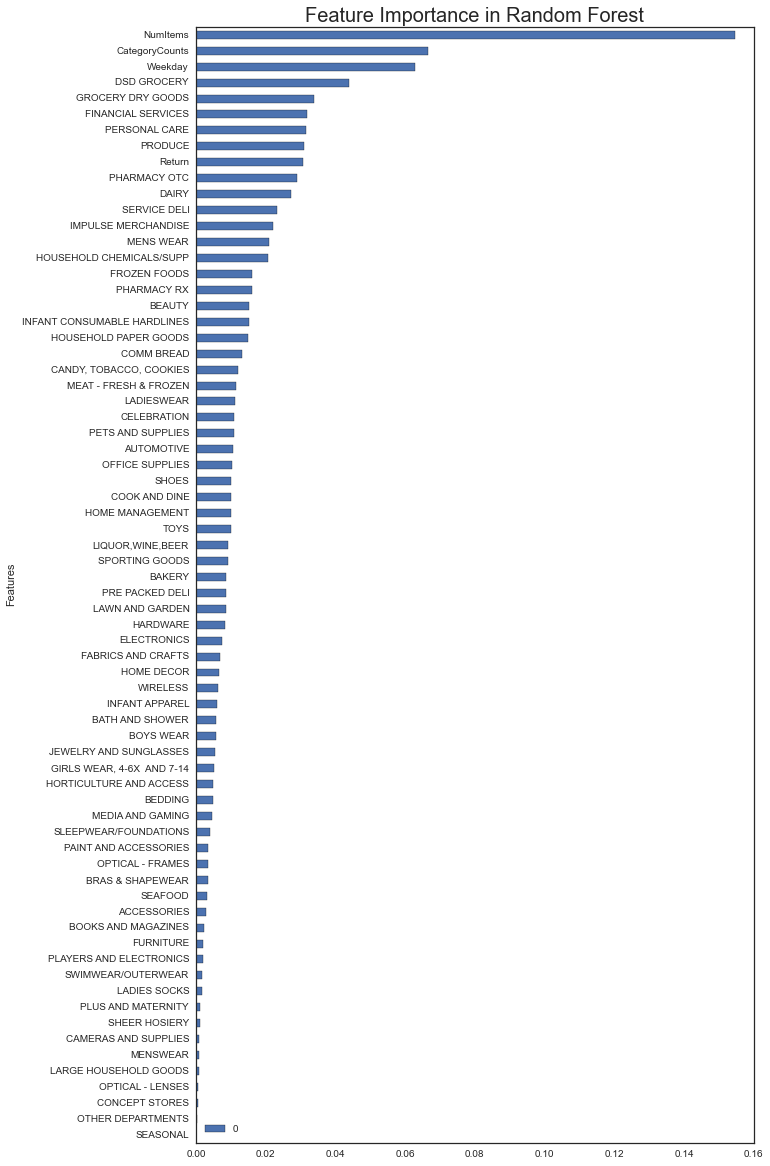

In [1315]:
x = forest.feature_importances_
graphing_results = pd.DataFrame(forest.feature_importances_).sort_index()
graphing_results["Features"] = features
graphing_results = graphing_results.set_index("Features").sort_values(by=0, ascending=True)
y = graphing_results.plot(kind="barh", figsize=(10,20), rot=0)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.title("Feature Importance in Random Forest", size=20)

In [1316]:
non_departments = x[0:3]
departments = x[4:]

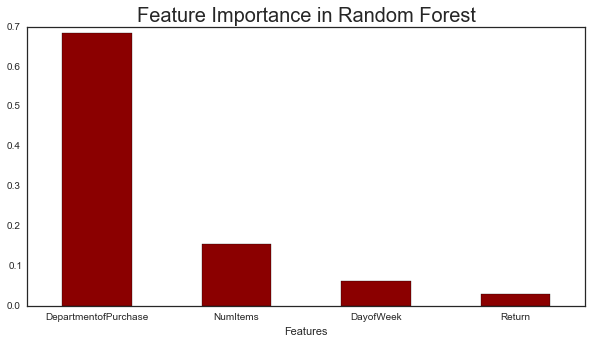

In [1317]:
departments = np.sum(departments)
department_data = np.append(non_departments, departments)

graphing_department = pd.DataFrame(department_data).sort_index()
graphing_department["Features"] = ["DayofWeek", "NumItems", "Return", "DepartmentofPurchase"]
graphing_department = graphing_department.set_index("Features").sort_values(by=0, ascending=False)

x = graphing_department.plot(kind="bar", figsize=(10,5), rot=0, color="darkred", legend=False)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=10)
plt.title("Feature Importance in Random Forest", size=20)

In [73]:
test_predictions = pd.DataFrame(test_predictions)
mytest_answers = mytest[["TripType"]]
mytest_answers = mytest_answers.rename(columns={"TripType": "WalmartClass"})
test_predictions = test_predictions.set_index(mytest_answers.index)
test_predictions = test_predictions.rename(columns={0: "Prediction"})
test_predictions = test_predictions.join(mytest_answers)
test_predictions["Prediction"] = test_predictions["Prediction"].map({0:3, 1:4, 2:5, 3:6, 4:7, 5:8, 6:9, 7:12, 8:14, 9:15,  
                                         10:18, 11:19, 12:20, 13:21, 14:22, 15:23, 16:24, 17:25, 18:26,  
                                         19:27, 20:28, 21:29, 22:30, 23:31, 24:32, 25:33, 26:34, 27:35, 
                                         28:36, 29:37, 30:38, 31:39, 32:40, 33:41, 34:42, 35:43, 36:44, 37:999})
test_predictions["WalmartClass"] = test_predictions["WalmartClass"].map({0:3, 1:4, 2:5, 3:6, 4:7, 5:8, 6:9, 7:12, 8:14, 9:15,  
                                         10:18, 11:19, 12:20, 13:21, 14:22, 15:23, 16:24, 17:25, 18:26,  
                                         19:27, 20:28, 21:29, 22:30, 23:31, 24:32, 25:33, 26:34, 27:35, 
                                         28:36, 29:37, 30:38, 31:39, 32:40, 33:41, 34:42, 35:43, 36:44, 37:999})
test_predictions = test_predictions[["WalmartClass", "Prediction"]]

#### Without max_delta_step

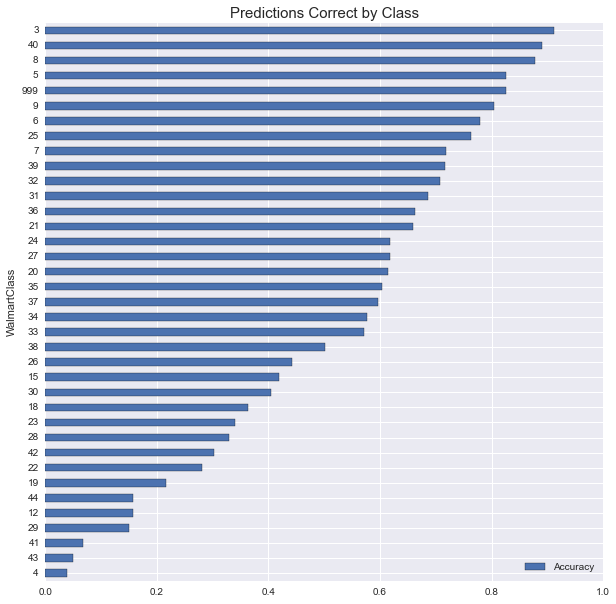

In [184]:
alist = []
for x, y in np.asarray(test_predictions):
    count = 0
    if x == y:
        count = 1
    alist.append(count)

correct = pd.DataFrame(alist)
correct = correct.set_index(mytest_answers.index)
correct = correct.rename(columns={0: "Result"})
test_predictions = test_predictions.join(correct)
prediction_accuracy = test_predictions.set_index(test_predictions["WalmartClass"])
prediction_accuracy = prediction_accuracy[["Result"]]

value_counts = pd.DataFrame(prediction_accuracy.index.value_counts())

diction_accuracy_groupby = test_predictions.groupby("WalmartClass")
prediction_accuracy_precentage = prediction_accuracy_groupby.agg({'WalmartClass': np.max,
                                                                  "Prediction": np.max,
                                                                  "Result": np.sum})

prediction_accuracy_precentage = prediction_accuracy_precentage[["Result"]]

value_counts = value_counts.sort_index()

prediction_accuracy_precentage = prediction_accuracy_precentage.join(value_counts)

prediction_accuracy_precentage["Accuracy"] = prediction_accuracy_precentage.Result / prediction_accuracy_precentage.WalmartClass

prediction_accuracy_precentage = prediction_accuracy_precentage.sort_values(by="Accuracy", ascending=True)

ax = prediction_accuracy_precentage[["Accuracy"]].plot(kind="barh", figsize=(10,10))
plt.title("Predictions Correct by Class", size=15)

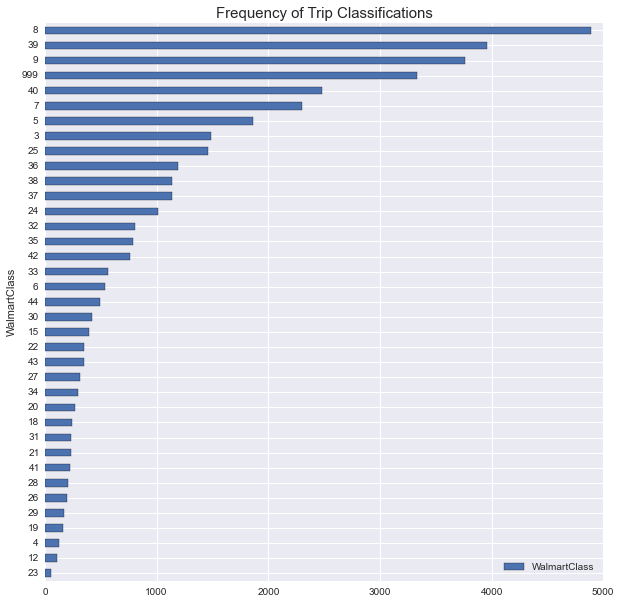

In [220]:
ax = prediction_accuracy_precentage_occurences[["WalmartClass"]].plot(kind="barh", figsize=(10,10))
plt.title("Frequency of Trip Classifications", size=15)

#### With max_delta_step

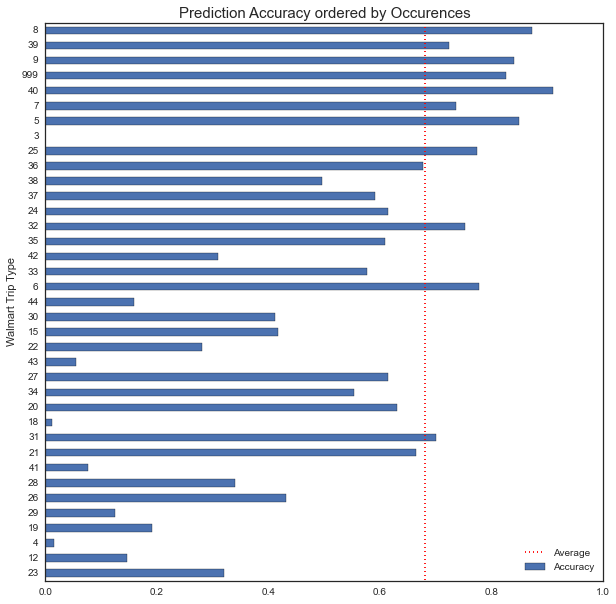

In [1300]:
prediction_accuracy_precentage_occurences = prediction_accuracy_precentage.sort_values("WalmartClass")
ax = prediction_accuracy_precentage_occurences[["Accuracy"]].plot(kind="barh", figsize=(10,10))
average_correct = prediction_accuracy_precentage["Result"].sum() / prediction_accuracy_precentage["WalmartClass"].sum()
plt.title("Prediction Accuracy ordered by Occurences", size=15)
plt.vlines(average_correct, -1, 40, color="red", linestyle="dotted")
ax.legend(["Average", "Accuracy"], loc=4)
ax.set_ylabel("Walmart Trip Type")

Accuracy goes down greatly depending on how many instances the model can learn from. <br>
This is a class imbalance problem! <br>
http://www.win-vector.com/blog/2015/02/does-balancing-classes-improve-classifier-performance/

In [1887]:
#my_test_wk_dummies = pd.get_dummies(mytest.Weekday)
#mytest[my_test_wk_dummies.columns] = my_test_wk_dummies 
#mytest = mytest.rename(columns={1:"Monday", 2:"Tuesday", 
                                #3:"Wednesday", 4:"Thursday",
                                #5: "Friday", 6:"Saturday", 7:"Sunday"})
mytestgrouped = mytest.groupby("TripType")
mytestgrouped = mytestgrouped.aggregate(np.mean)

In [1872]:
#data1grouped = data1.groupby("TripType")
#data1grouped = data1grouped.aggregate(np.mean)
#data1grouped = data1grouped.reset_index("TripType", [x for x in range(38)]) 
#data1grouped = data1grouped.join(days_of_week)
#data1grouped = data1grouped.dropna()
#del data1grouped['Weekday']

In [1891]:
mytestgrouped_categories = mytestgrouped.ix[:,4:72]

In [1893]:
mytestgrouped_categories["OPTICAL"] = mytestgrouped_categories["OPTICAL - LENSES"] + mytestgrouped_categories["OPTICAL - FRAMES"]
del mytestgrouped_categories["OPTICAL - FRAMES"]
del mytestgrouped_categories["OPTICAL - LENSES"]
del mytestgrouped_categories["CONCEPT STORES"]
del mytestgrouped_categories["HEALTH AND BEAUTY AIDS"]
del mytestgrouped_categories["OTHER DEPARTMENTS"]
mytestgrouped_categories["DELI"] = mytestgrouped_categories["SERVICE DELI"] + mytestgrouped_categories["PRE PACKED DELI"]
del mytestgrouped_categories["PRE PACKED DELI"]
del mytestgrouped_categories["SERVICE DELI"]
mytestgrouped_categories["WOMENS CLOTHES"] = mytestgrouped_categories["PLUS AND MATERNITY"] + mytestgrouped_categories["LADIES SOCKS"] + mytestgrouped_categories["LADIES SOCKS"] + mytestgrouped_categories["BRAS & SHAPEWEAR"]
del mytestgrouped_categories["PLUS AND MATERNITY"]
del mytestgrouped_categories["LADIES SOCKS"]
del mytestgrouped_categories["BRAS & SHAPEWEAR"]
mytestgrouped_categories["ELECTRONICS"] = mytestgrouped_categories["ELECTRONICS"] + mytestgrouped_categories["PLAYERS AND ELECTRONICS"]
del mytestgrouped_categories["PLAYERS AND ELECTRONICS"]
mytestgrouped_categories["LADIESWEAR"] = mytestgrouped_categories["LADIESWEAR"] + mytestgrouped_categories["WOMENS CLOTHES"]
del mytestgrouped_categories["WOMENS CLOTHES"]
mytestgrouped_categories["PHARMACY"] = mytestgrouped_categories["PHARMACY RX"] + mytestgrouped_categories["PHARMACY OTC"]
del mytestgrouped_categories["PHARMACY RX"] 
del mytestgrouped_categories["PHARMACY OTC"]
mytestgrouped_categories["LAWN AND GARDEN"] = mytestgrouped_categories["LAWN AND GARDEN"] + mytestgrouped_categories["HORTICULTURE AND ACCESS"]
del mytestgrouped_categories["HORTICULTURE AND ACCESS"]
mytestgrouped_categories["LADIESWEAR"] = mytestgrouped_categories["SHEER HOSIERY"] + mytestgrouped_categories["LADIESWEAR"]
del mytestgrouped_categories["SHEER HOSIERY"] 
mytestgrouped_categories["CLOTHES"] = mytestgrouped_categories["BOYS WEAR"] + mytestgrouped_categories["MENSWEAR"] + mytestgrouped_categories["SWIMWEAR/OUTERWEAR"] + mytestgrouped_categories['GIRLS WEAR, 4-6X  AND 7-14'] + mytestgrouped_categories["INFANT APPAREL"] + mytestgrouped_categories["LADIESWEAR"] + mytestgrouped_categories["MENS WEAR"] + mytestgrouped_categories["SLEEPWEAR/FOUNDATIONS"]    
del mytestgrouped_categories["BOYS WEAR"] 
del mytestgrouped_categories["MENSWEAR"] 
del mytestgrouped_categories["SWIMWEAR/OUTERWEAR"] 
del mytestgrouped_categories['GIRLS WEAR, 4-6X  AND 7-14'] 
del mytestgrouped_categories["INFANT APPAREL"] 
del mytestgrouped_categories["LADIESWEAR"] 
del mytestgrouped_categories["MENS WEAR"] 
del mytestgrouped_categories["SLEEPWEAR/FOUNDATIONS"]
mytestgrouped_categories["GROCERIES"] = mytestgrouped_categories["BAKERY"] + mytestgrouped_categories["COMM BREAD"] + mytestgrouped_categories["DAIRY"] + mytestgrouped_categories["DSD GROCERY"] + mytestgrouped_categories["FROZEN FOODS"] + mytestgrouped_categories["GROCERY DRY GOODS"] + mytestgrouped_categories["MEAT - FRESH & FROZEN"] + mytestgrouped_categories["PRODUCE"] + mytestgrouped_categories["SEAFOOD"] + mytestgrouped_categories["DELI"]
del mytestgrouped_categories["BAKERY"]
del mytestgrouped_categories["COMM BREAD"]
del mytestgrouped_categories["DAIRY"]
del mytestgrouped_categories["DSD GROCERY"]
del mytestgrouped_categories["FROZEN FOODS"]
del mytestgrouped_categories["GROCERY DRY GOODS"]
del mytestgrouped_categories["MEAT - FRESH & FROZEN"]
del mytestgrouped_categories["PRODUCE"]
del mytestgrouped_categories["SEAFOOD"]
del mytestgrouped_categories["DELI"]
mytestgrouped_categories["CLOTHES"] = mytestgrouped_categories["CLOTHES"] + mytestgrouped_categories["SHOES"]
del mytestgrouped_categories["SHOES"]
mytestgrouped_categories["HOME"] = mytestgrouped_categories["BATH AND SHOWER"] + mytestgrouped_categories["HOME DECOR"] + mytestgrouped_categories["HOME MANAGEMENT"] + mytestgrouped_categories["BEDDING"] + mytestgrouped_categories["COOK AND DINE"] + mytestgrouped_categories["FURNITURE"] + mytestgrouped_categories["LARGE HOUSEHOLD GOODS"] + mytestgrouped_categories["SEASONAL"]      
del mytestgrouped_categories["HOME DECOR"]
del mytestgrouped_categories["BATH AND SHOWER"]
del mytestgrouped_categories["HOME MANAGEMENT"]
del mytestgrouped_categories["BEDDING"]
del mytestgrouped_categories["COOK AND DINE"]
del mytestgrouped_categories["FURNITURE"]
del mytestgrouped_categories["LARGE HOUSEHOLD GOODS"]
del mytestgrouped_categories["SEASONAL"]
mytestgrouped_categories["JEWELRY AND ACCESSORIES"] = mytestgrouped_categories["JEWELRY AND SUNGLASSES"] + mytestgrouped_categories["ACCESSORIES"]    
del mytestgrouped_categories["JEWELRY AND SUNGLASSES"] 
del mytestgrouped_categories["ACCESSORIES"]
mytestgrouped_categories["ELECTRONICS"] = mytestgrouped_categories["ELECTRONICS"] + mytestgrouped_categories["CAMERAS AND SUPPLIES"]
del mytestgrouped_categories["CAMERAS AND SUPPLIES"]
mytestgrouped_categories['HOUSEHOLD GOODS'] = mytestgrouped_categories['HOUSEHOLD PAPER GOODS'] + mytestgrouped_categories['HOUSEHOLD CHEMICALS/SUPP'] 
del mytestgrouped_categories['HOUSEHOLD CHEMICALS/SUPP'] 
del mytestgrouped_categories['HOUSEHOLD PAPER GOODS']
mytestgrouped_categories["ELECTRONICS"] = mytestgrouped_categories["ELECTRONICS"] + mytestgrouped_categories["WIRELESS"]
del mytestgrouped_categories["WIRELESS"]
mytestgrouped_categories["BEAUTY AND PERSONAL CARE"] = mytestgrouped_categories["BEAUTY"] + mytestgrouped_categories["PERSONAL CARE"]
del mytestgrouped_categories["BEAUTY"]
del mytestgrouped_categories["PERSONAL CARE"]
# --------------------
# Really Good Graph From this 


/Users/MattKasle/Matt/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/MattKasle/Matt/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/MattKasle/Matt/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [1894]:
mytestgrouped_categories_norm = (mytestgrouped_categories - mytestgrouped_categories.mean()) / (mytestgrouped_categories.max() - mytestgrouped_categories.min())

In [1923]:
days_of_week
days_of_week_norm = (days_of_week - days_of_week.mean()) / (days_of_week.max() - days_of_week.min())

In [1896]:
mytestgrouped_categories_norm.head()

,1-HR PHOTO,AUTOMOTIVE,BOOKS AND MAGAZINES,"CANDY, TOBACCO, COOKIES",CELEBRATION,ELECTRONICS,FABRICS AND CRAFTS,FINANCIAL SERVICES,HARDWARE,IMPULSE MERCHANDISE,...,SPORTING GOODS,TOYS,OPTICAL,PHARMACY,CLOTHES,GROCERIES,HOME,JEWELRY AND ACCESSORIES,HOUSEHOLD GOODS,BEAUTY AND PERSONAL CARE
TripType,,,,,,,,,,,,,,,,,,,,,
0,-0.030157,-0.040633,-0.100610,-0.155534,-0.062773,-0.092838,-0.046585,0.930847,-0.059019,-0.092882,...,-0.048138,-0.068573,-0.033769,-0.136883,-0.120324,-0.117914,-0.082446,-0.070590,-0.095824,-0.119977
1,-0.033459,-0.040073,-0.106210,-0.116987,-0.058851,-0.095667,-0.046729,-0.064520,-0.061124,-0.130672,...,-0.048824,-0.068573,-0.040682,0.788941,-0.120877,-0.086296,-0.086254,-0.068582,-0.082143,-0.091434
2,-0.030746,-0.039743,-0.097005,-0.107398,-0.056649,-0.093674,-0.044601,-0.060200,-0.055243,-0.162772,...,-0.049110,-0.068030,0.959318,0.857704,-0.108688,-0.096383,-0.081700,-0.070391,-0.083683,-0.061155
3,-0.023718,-0.042664,-0.089686,0.831960,-0.052740,-0.093282,-0.042910,-0.061117,-0.056156,-0.126891,...,-0.047707,-0.067599,-0.040682,-0.122903,-0.118565,-0.077614,-0.078538,-0.075189,-0.080794,-0.102311
4,-0.027114,-0.039574,-0.088272,-0.119972,-0.062385,-0.093596,-0.045899,-0.062465,-0.056540,-0.165678,...,-0.049285,-0.067515,-0.036253,-0.126445,-0.118097,0.065919,-0.087023,-0.073209,-0.078303,-0.112295


In [1900]:
#items_return_category_counts = mytestgrouped_categories_norm.iloc[:,1:4]
days_of_week
items_return_category_counts_days = items_return_category_counts.join(days_of_week)

In [1926]:
items_return_category_counts_days.iloc[:,3:11] = days_of_week_norm

In [1914]:
#mytestgrouped_categories_norm.insert(0, "NumItems", 
                                     #items_return_category_counts_days.iloc[:,0:1])
mytestgrouped_categories_norm.insert(1, "Return", 
                                     items_return_category_counts_days.iloc[:,1:2])
mytestgrouped_categories_norm.insert(2, "CategoryCount", 
                                     items_return_category_counts_days.iloc[:,2:3])
mytestgrouped_categories_norm.insert(3, "Monday", 
                                     items_return_category_counts_days.iloc[:,3:4])
mytestgrouped_categories_norm.insert(4, "Tuesday", 
                                     items_return_category_counts_days.iloc[:,4:5])
mytestgrouped_categories_norm.insert(5, "Wednesday", 
                                     items_return_category_counts_days.iloc[:,5:6])
mytestgrouped_categories_norm.insert(6, "Thursday", 
                                     items_return_category_counts_days.iloc[:,6:7])
mytestgrouped_categories_norm.insert(7, "Friday", 
                                     items_return_category_counts_days.iloc[:,7:8])
mytestgrouped_categories_norm.insert(8, "Saturday", 
                                     items_return_category_counts_days.iloc[:,8:9])
mytestgrouped_categories_norm.insert(9, "Sunday", 
                                     items_return_category_counts_days.iloc[:,9:10])

In [1931]:
mytestgrouped_categories_norm.iloc[:,3:10] = days_of_week_norm

In [1933]:
mytestgrouped_categories_norm = mytestgrouped_categories_norm.fillna(0)

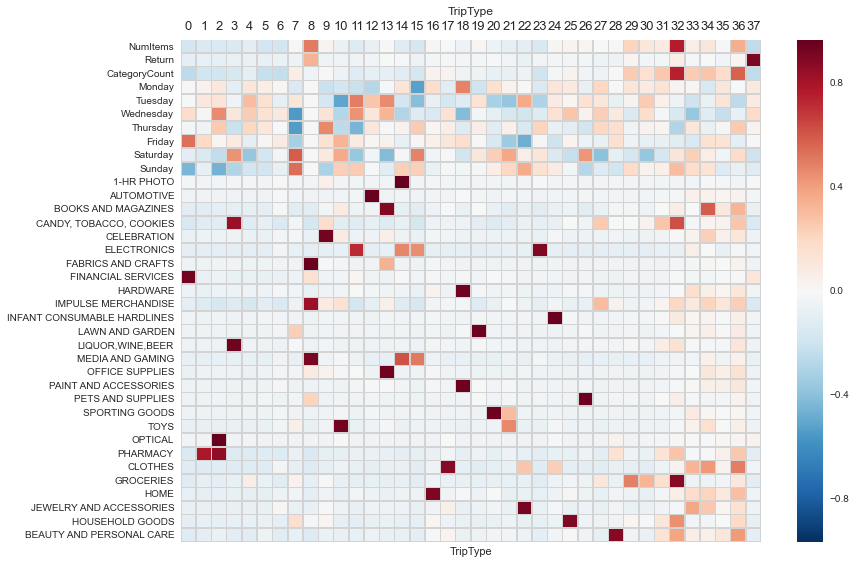

In [1943]:
a4_dims = (13, 9)
fig, ax = plt.subplots(figsize=a4_dims)
seaborn.heatmap(ax=ax, data=mytestgrouped_categories_norm.T, linecolor='lightgrey', linewidths=.00000000000000001)
#heatmap = ax.pcolor(mytestgrouped_categories_norm, cmap=plt.cm.Blues, alpha=0.8)
#ax.set_xticklabels(mytestgrouped_categories.columns, minor=False)
#ax.set_yticklabels(mytestgrouped_categories_norm.index, minor=False)
#ax.invert_yaxis()
ax.xaxis.tick_top()
#ax.set_yticks(np.arange(mytestgrouped_categories_norm.shape[1]) + 1, minor=False)
#ax.set_xticks(np.arange(mytestgrouped_categories_norm.shape[0]) + 1, minor=False)
#plt.xticks(rotation=90)
#plt.rc('xtick', labelsize=10)
plt.title('TripType',y=1.04)


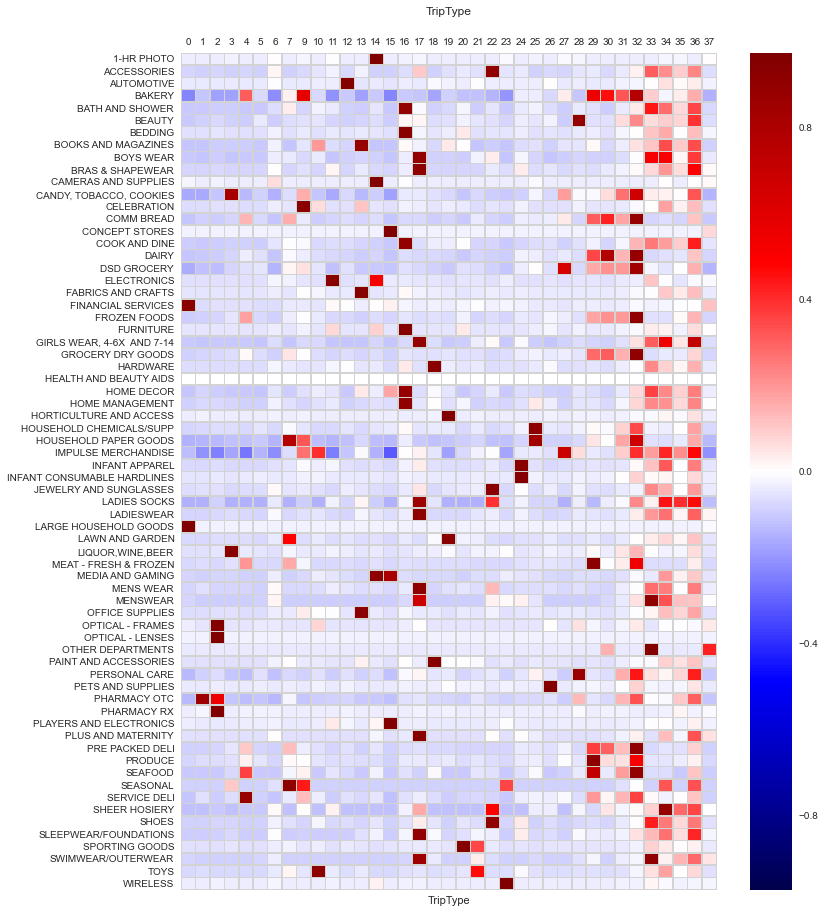

In [970]:

a4_dims = (12, 15)
fig, ax = plt.subplots(figsize=a4_dims)
seaborn.heatmap(ax=ax, data=mytestgrouped_categories_norm_original.T.sort_index(), cmap = 'seismic', linecolor='lightgrey', linewidths=.00000000000000001)
#heatmap = ax.pcolor(mytestgrouped_categories_norm, cmap=plt.cm.Blues, alpha=0.8)
#ax.set_xticklabels(mytestgrouped_categories.columns, minor=False)
#ax.set_yticklabels(mytestgrouped_categories_norm.index, minor=False)
#ax.invert_yaxis()
ax.xaxis.tick_top()
#ax.set_yticks(np.arange(mytestgrouped_categories_norm.shape[1]) + 1, minor=False)
#ax.set_xticks(np.arange(mytestgrouped_categories_norm.shape[0]) + 1, minor=False)
#plt.xticks(rotation=90)
#plt.rc('xtick', labelsize=10)
plt.title('TripType',y=1.04)


When is a return most likely to happen -- during the week

Classifying Customers:

'The Macy's Shopper' (Trip 17) <br> 
Likely to buy: Boys' Wear, Girls' Wear, Bras, Ladieswear, Menswear, Plus and Maternity, Sleepwear, Swimwear <br>
Likely to shop on:

The Booze Run (Trip 3) <br>
Candy and Tobacco + Liquor, Wine, and Beer

Who's likely to make 'impulse goods'? <br>
1) People who go to buy party supplies, seasonal items, and take a trip to the bakery (for a cake?) (Trip 9)
2) People going to primarily buy toys. 

Trip 13
When people go to the store for fabrics and office supplies, they are also the most likely person to purchase a book or magazine.

Food is so important to Walmart's business that it is the most purchased.... and takes up about 5 different categories.

Many of the trips show someone making a quick trip to Walmart for a singular purpose, such as purchasing 1) Pet Food 2) Automotive goods 3) 1 HR-Photos 4) Infant Goods 5) Paint and Hardware

In [1223]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [1290]:
kmeans = KMeans(2)
y_pred = kmeans.fit_predict(mytestgrouped_categories_norm)

In [1291]:
pca = PCA(n_components=2)
pca.fit(mytestgrouped_categories_norm)
mytestgrouped_reduced = pca.transform(mytestgrouped_categories_norm)

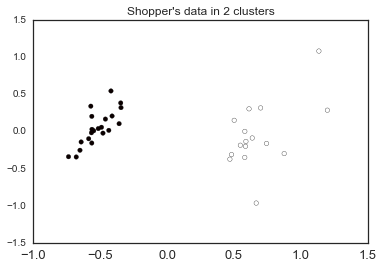

In [1415]:
plt.scatter(mytestgrouped_reduced[:, 0], mytestgrouped_reduced[:, 1], c=y_pred, cmap="hot")
plt.title("Shopper's data in 2 clusters")
plt.show()

In [1293]:
mytestgrouped_categories_norm['Clusters'] = y_pred

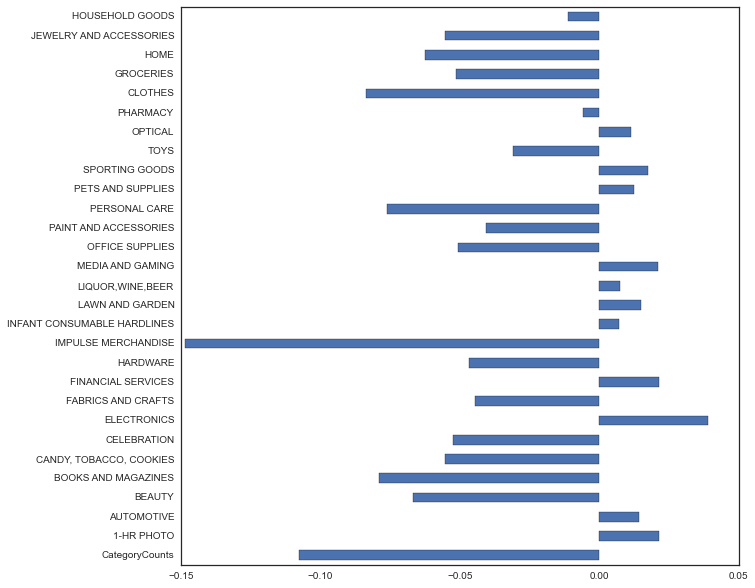

In [1294]:
mytestgrouped_categories_norm.loc[mytestgrouped_categories_norm.Clusters == 0].iloc[:,:-1].mean().plot(kind='barh', figsize=(10,10))

In [1296]:
cluster_0 = mytestgrouped_categories_norm.loc[mytestgrouped_categories_norm.Clusters == 0]

In [1297]:
cluster_1 = mytestgrouped_categories_norm.loc[mytestgrouped_categories_norm.Clusters == 1]

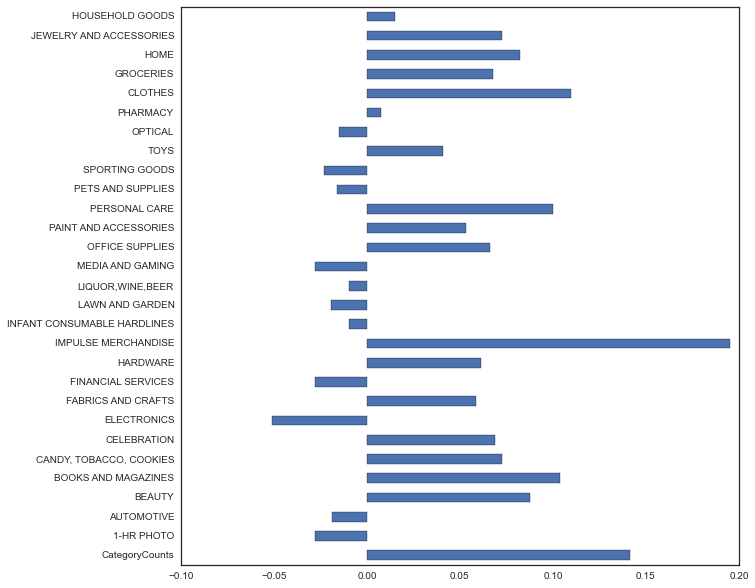

In [1286]:
mytestgrouped_categories_norm.loc[mytestgrouped_categories_norm.Clusters == 1].iloc[:,:-1].mean().plot(kind='barh', figsize=(10,10))

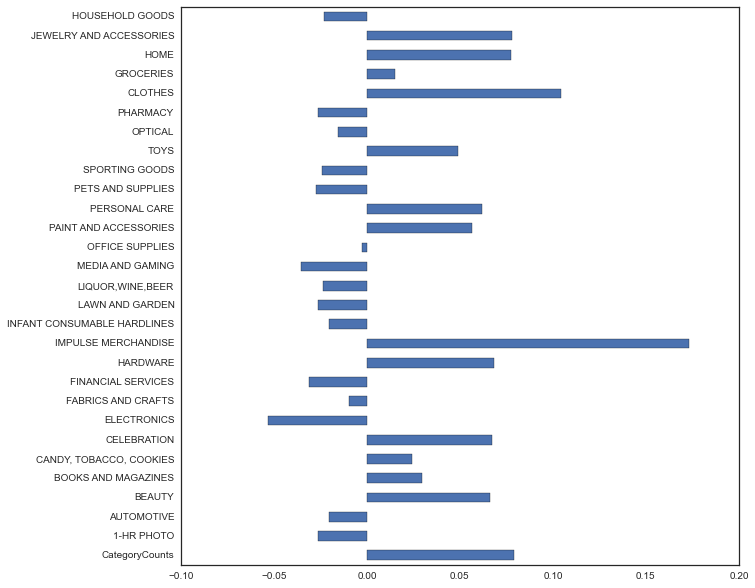

In [1246]:
mytestgrouped_categories_norm.loc[mytestgrouped_categories_norm.Clusters == 3].iloc[:,:-1].mean().plot(kind='barh', figsize=(10,10))

In [1362]:
cluster_1.index

Int64Index([9, 10, 13, 16, 17, 18, 22, 27, 28, 29, 31, 32, 33, 34, 35, 36], dtype='int64', name='TripType')

In [1382]:
cluster_1_data = data1grouped.iloc[cluster_1.index -1]

In [1392]:
cluster_0_data = data1grouped.iloc[cluster_0.index -1][1:]

In [1401]:
cluster_0_means = cluster_0_data.mean()
cluster_1_means = cluster_1_data.mean()

In [1488]:
log_loss(mytest.TripType, test_predictions1).round(5)

0.84730000000000005

In [1498]:
test_predictions_df = pd.DataFrame(test_predictions1).set_index(mytest.index)

In [1496]:
mytest.index

Int64Index([ 30365, 104896, 129484, 130211,  14804,  44058, 128385, 107284,
             76242, 171503,
            ...
             98030, 116322,  70508,  57161,  26180, 117910, 179777,  46730,
             75261, 176066],
           dtype='int64', name='VisitNumber', length=38270)

In [1520]:
pd.DataFrame(test_predictions_df.max(axis=1)).rename(columns={0:"Probability"}).head()

,Probability
VisitNumber,
30365,0.932102
104896,0.743857
129484,0.999257
130211,0.881695
14804,0.354972


In [1517]:
test_predictions_max = pd.DataFrame(test_predictions_df.idxmax(axis=1)).rename(columns={0:"TripType"}).join(pd.DataFrame(test_predictions_df.max(axis=1)).rename(columns={0:"Probability"}))

In [1519]:
test_predictions_max.head()

,TripType,Probability
VisitNumber,,
30365,17,0.932102
104896,9,0.743857
129484,37,0.999257
130211,24,0.881695
14804,31,0.354972


In [1608]:
top_three_probs = pd.DataFrame(np.sort(test_predictions1, axis=1)).iloc[:,35:38]
top_three_probs = top_three_probs[[37, 36, 35]]
top_three_probs = top_three_probs.rename(columns={37:"Probability1", 36:"Probability2", 35:"Probability3"})

In [1619]:
def return_probabilities(predictions_array):
    top_three_probs = pd.DataFrame(np.sort(predictions_array, axis=1)).iloc[:,35:38]
    top_three_probs = top_three_probs[[37, 36, 35]]
    top_three_probs = top_three_probs.rename(columns={37:"Probability1", 36:"Probability2", 35:"Probability3"})

    top_three_types =  pd.DataFrame(np.argsort(predictions_array, axis=1)).iloc[:,35:38]
    top_three_types = top_three_types[[37, 36, 35]]
    top_three_types = top_three_types.rename(columns={37:"Most Likely", 36:"Second Most Likely", 35:"Third Most Likely"})
    top_three_types = top_three_types.astype(str)

    top_three_combined = top_three_types.join(top_three_probs)
    top_three_combined = top_three_combined[["Most Likely", "Probability1", "Second Most Likely", 
                                             "Probability2", "Third Most Likely", "Probability3"]]
    top_three_combined = top_three_combined.rename(columns={"Probability1": "1st Probability", 
                                            "Probability2": "2nd Probability", "Probability3": "3rd Probability"})
    return top_three_combined

In [1610]:
top_three_probs.head()

,Probability1,Probability2,Probability3
0,0.932102,0.020483,0.019415
1,0.743857,0.064125,0.056784
2,0.999257,0.000611,0.000066
3,0.881695,0.045226,0.026878
4,0.354972,0.319159,0.204149


In [1611]:
top_three_types.head()

,Most Likely,Second Most Likely,Third Most Likely
0,17,37,6
1,9,31,34
2,37,6,5
3,24,17,35
4,31,24,29


In [1612]:
top_three_combined = top_three_types.join(top_three_probs)
top_three_combined = top_three_combined[["Most Likely", "Probability1", "Second Most Likely", 
                                         "Probability2", "Third Most Likely", "Probability3"]]
top_three_combined = top_three_combined.rename(columns={"Probability1": "1st Probability", 
                                        "Probability2": "2nd Probability", "Probability3": "3rd Probability"})

In [1587]:
my_test_sample = xgb.DMatrix(np.asarray(mytest_train.iloc[0:1]))
test_predictions_sample = bst.predict(my_test_sample)

In [1620]:
return_probabilities(test_predictions_sample)

,Most Likely,1st Probability,Second Most Likely,2nd Probability,Third Most Likely,3rd Probability
0,17,0.932102,37,0.020483,6,0.019415


In [1680]:
mytest_train.iloc[0:1].loc[(mytest_train.iloc[0:1] != 0).any(1)]

,Weekday,NumItems,Return,CategoryCounts,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,...,805.0,3704.0,4500.0,1352.0,3175.0,1009.0,2804.0,2352.0,10.0,7557.0
VisitNumber,,,,,,,,,,,,,,,,,,,,,
30365,2,4,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1742]:
df_sample = mytest_train.iloc[0:1]

In [1761]:

def make_and_return_predictions(data):
    my_test_sample = xgb.DMatrix(np.asarray(data))
    test_predictions_sample = bst.predict(my_test_sample)
    top_three_probs = pd.DataFrame(np.sort(test_predictions_sample, axis=1)).iloc[:,35:38]
    top_three_probs = top_three_probs[[37, 36, 35]]
    top_three_probs = top_three_probs.rename(columns={37:"Probability1", 36:"Probability2", 35:"Probability3"})

    top_three_types =  pd.DataFrame(np.argsort(test_predictions_sample, axis=1)).iloc[:,35:38]
    top_three_types = top_three_types[[37, 36, 35]]
    top_three_types = top_three_types.rename(columns={37:"Most Likely", 36:"Second Most Likely", 35:"Third Most Likely"})
    top_three_types = top_three_types.astype(str)

    top_three_combined = top_three_types.join(top_three_probs)
    top_three_combined = top_three_combined[["Most Likely", "Probability1", "Second Most Likely", 
                                             "Probability2", "Third Most Likely", "Probability3"]]
    top_three_combined = top_three_combined.rename(columns={"Probability1": "1st Probability", 
                                            "Probability2": "2nd Probability", "Probability3": "3rd Probability"})
    return top_three_combined

def non_zeros(data):   
    df_sample_short = data[data != 0].dropna(axis=1)
    return df_sample_short

In [1708]:
x = make_predictions(df_sample)

,Most Likely,1st Probability,Second Most Likely,2nd Probability,Third Most Likely,3rd Probability
0,10,0.770337,21,0.117212,7,0.067522


In [1758]:
df_sample = df_sample.reset_index()
del df_sample["VisitNumber"]
df_sample["Weekday"] = 0
df_sample["NumItems"] = 0
df_sample["CategoryCounts"] = 0
df_sample["BOYS WEAR"] = 0


In [1759]:
df_sample

,Weekday,NumItems,Return,CategoryCounts,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,...,805.0,3704.0,4500.0,1352.0,3175.0,1009.0,2804.0,2352.0,10.0,7557.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1762]:
non_zeros(df_sample)

,Weekday,NumItems,CategoryCounts,TOYS
0,6,4,1,4


In [1763]:
make_and_return_predictions(df_sample)

,Most Likely,1st Probability,Second Most Likely,2nd Probability,Third Most Likely,3rd Probability
0,10,0.830562,21,0.11014,7,0.021242


In [2035]:
df_sample['ACCESSORIES'] = 0
df_sample['AUTOMOTIVE'] = 0
df_sample['BAKERY'] = 0
df_sample['BATH AND SHOWER'] = 0
df_sample['BEAUTY'] = 0
df_sample['BEDDING'] = 0
df_sample['BOOKS AND MAGAZINES'] = 2
df_sample['BOYS WEAR'] = 0
df_sample['BRAS & SHAPEWEAR'] = 0
df_sample['CAMERAS AND SUPPLIES'] = 0
df_sample['CANDY, TOBACCO, COOKIES'] = 0
df_sample['CELEBRATION'] = 0
df_sample['COMM BREAD'] = 0
df_sample['CONCEPT STORES'] = 0
df_sample['COOK AND DINE'] = 0
df_sample['DAIRY'] = 0
df_sample['DSD GROCERY'] = 0
df_sample['ELECTRONICS'] = 0
df_sample['FABRICS AND CRAFTS'] = 0
df_sample['FINANCIAL SERVICES'] = 4
df_sample['FROZEN FOODS'] = 0
df_sample['FURNITURE'] = 0
df_sample['GIRLS WEAR, 4-6X  AND 7-14'] = 0
df_sample['GROCERY DRY GOODS'] = 0
df_sample['HARDWARE'] = 0
df_sample['HOME DECOR'] = 0
df_sample['HOME MANAGEMENT'] = 0
df_sample['HORTICULTURE AND ACCESS'] = 0
df_sample['HOUSEHOLD CHEMICALS/SUPP'] = 0
df_sample['HOUSEHOLD PAPER GOODS'] = 0
df_sample['IMPULSE MERCHANDISE'] = 0
df_sample['INFANT APPAREL'] = 0
df_sample['INFANT CONSUMABLE HARDLINES'] = 0
df_sample['JEWELRY AND SUNGLASSES'] = 0
df_sample['LADIES SOCKS'] = 0
df_sample['LADIESWEAR'] = 0
df_sample['LARGE HOUSEHOLD GOODS'] = 0
df_sample['LAWN AND GARDEN'] = 0
df_sample['LIQUOR,WINE,BEER'] = 0
df_sample['MEAT - FRESH & FROZEN'] = 0
df_sample['MEDIA AND GAMING'] = 0
df_sample['MENS WEAR'] = 0
df_sample['MENSWEAR'] = 0
df_sample['OFFICE SUPPLIES'] = 0
df_sample['OPTICAL - FRAMES'] = 0
df_sample['OPTICAL - LENSES'] = 0
df_sample['OTHER DEPARTMENTS'] = 0
df_sample['PAINT AND ACCESSORIES'] = 0
df_sample['PERSONAL CARE'] = 0
df_sample['PETS AND SUPPLIES'] = 0
df_sample['PHARMACY OTC'] = 0
df_sample['PHARMACY RX'] = 0
df_sample['PLAYERS AND ELECTRONICS'] = 0
df_sample['PLUS AND MATERNITY'] = 0
df_sample['PRE PACKED DELI'] = 0
df_sample['PRODUCE'] = 0
df_sample['SEAFOOD'] = 0
df_sample['SEASONAL'] = 0
df_sample['SERVICE DELI'] = 0
df_sample['SHEER HOSIERY'] = 0
df_sample['SHOES'] = 0
df_sample['SLEEPWEAR/FOUNDATIONS'] = 3
df_sample['SPORTING GOODS'] = 0
df_sample['SWIMWEAR/OUTERWEAR'] = 0
df_sample['TOYS'] = 0
df_sample['WIRELESS'] = 0

df_sample['Weekday'] = 6
df_sample['NumItems'] = 9
df_sample['Return'] = 0
df_sample['CategoryCounts'] = 0

non_zeros(df_sample)

,Weekday,NumItems,BOOKS AND MAGAZINES,FINANCIAL SERVICES,SLEEPWEAR/FOUNDATIONS
0,6,9,2,4,3


In [2036]:
x = make_predictions(df_sample)
return_probabilities(x)

,Most Likely,1st Probability,Second Most Likely,2nd Probability,Third Most Likely,3rd Probability
0,17,0.6747,37,0.193013,10,0.022748


TripTypes <br>
0: Financial Services Trip <br>
1: Pharmacy Trip <br>
2: Opticals and Pharmacy Trip <br>
3: The Vices Trip  <br>
4: Quick Grocery Run  <br>
5: Miscellaneous #2  <br>
6: Miscellaneous #3  <br>
7: Weekend Miscellaneous <br>
8: Bed Bath and Beyond Trip  <br>
9: Party City Trip  <br>
10: Toys-R-Us Trip  <br>
11: Best Buy Trip  <br>
12: Auto Store Trip  <br>
13: Staples Trip  <br>
14: 1-HR Photo and Camera Trip  <br>
15: Weekend Best Buy Trip  <br>
16: Crate & Barrel Trip  <br>
17: Clothing Trip  <br>
18: Hardware Trip  <br>
19: Lawn and Garden Trip  <br>
20: Sporting Goods Trip  <br>
21: Toys and Sporting Goods Trip  <br>
22: Jewelry Trip  <br>
23: Cellphone/Seasonal Trip  <br>
24: Diaper Run <br>
25: Toilet Paper and Cleanings Supply Run  <br>
26: Pets Trip  <br>
27: Junk Food Run  <br>
28: Beauty Aisle Trip  <br>
29: Full Grocery Trip  <br>
30: Grocery Staples Trip  <br>
31: General Grocery Trip  <br>
32: Grocery and Household Trip  <br>
33: Clothes and Grocery Trip    <br>
34: Everything Trip  <br>
35: Woman's Clothes and Home Trip  <br>
36: The Household and Everything Trip <br>
37: Returns Trip  <br>


